## Distribution of TAD strength scores
Using some advanced techniques, it's possible to calculate an arbitrary score for each snippet that contributed to the final pileup, and save those values within the pileup dataframe. This can be used to investigate whether the contribution features are all similar, or only some outliers cause enrichment.

Here as an example, we can calculate and store the TAD strength for each TAD that was averaged.

In [1]:
# If you are a developer, you may want to reload the packages on a fly. 
# Jupyter has a magic for this particular purpose:
%load_ext autoreload
%autoreload 2

In [2]:
# import standard python libraries
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 96
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
# import libraries for biological data analysis
from coolpuppy import coolpup
from plotpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools.lib import io
from cooltools import insulation, expected_cis
from cooltools.lib import plotting

In [4]:
# Downloading test data for pileups
# cache = True will doanload the data only if it was not previously downloaded
# data_dir="./" will force download to the current directory
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')
# Open cool file with Micro-C data:
clr = cooler.Cooler(f'{cool_file}::/resolutions/10000')
# Set up selected data resolution:
resolution = 10000

In [5]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
hg38_arms = hg38_arms.set_index("chrom").loc[clr.chromnames].reset_index()
# call this to automaticly assign names to chromosomal arms:
hg38_arms = bioframe.make_viewframe(hg38_arms)

In [6]:
# Calculate expected interactions for chromosome arms
expected = expected_cis(
    clr,
    ignore_diags=0,
    view_df=hg38_arms,
    chunksize=1000000)

First we need to generate coordinates of TADs. It's quite simple using cooltools.insulation: we get coordinates of strongly insulating regions, which likely correspond to TAD boundaries. Then we just need to combine consecutive boundaries, filter out super long domains, and we have a list of TAD coordiantes.

In [7]:
insul_df = insulation(clr, window_bp=50000, view_df=hg38_arms, nproc=4,)
insul_df

,chrom,start,end,region,is_bad_bin,log2_insulation_score_50000,n_valid_pixels_50000,boundary_strength_50000,is_boundary_50000
0,chr2,0,10000,chr2_p,True,NaN,0.0,NaN,False
1,chr2,10000,20000,chr2_p,False,0.509774,3.0,NaN,False
2,chr2,20000,30000,chr2_p,False,0.401887,7.0,NaN,False
3,chr2,30000,40000,chr2_p,False,0.380228,12.0,NaN,False
4,chr2,40000,50000,chr2_p,False,0.196502,17.0,NaN,False
...,...,...,...,...,...,...,...,...,...
32541,chr17,83210000,83220000,chr17_q,True,NaN,0.0,NaN,False
32542,chr17,83220000,83230000,chr17_q,True,NaN,0.0,NaN,False
32543,chr17,83230000,83240000,chr17_q,True,NaN,0.0,NaN,False
32544,chr17,83240000,83250000,chr17_q,True,NaN,0.0,NaN,False


In [8]:
# A  useful function to combine insulation score valleys into TADs and filter out very long "TADs"
def make_tads(insul_df, maxlen=1_500_000):
        tads = (
        insul_df.groupby("chrom")
        .apply(
            lambda x: pd.concat(
                [x[:-1].reset_index(drop=True), x[1:].reset_index(drop=True)],
                axis=1,
                ignore_index=True,
            )
        )
        .reset_index(drop=True)
        )
        tads.columns = [["chrom1", "start1", "end1", "chrom2", "start2", "end2"]]
        tads.columns = tads.columns.get_level_values(0)
        tads = tads[
            (tads["start2"] - tads["start1"]) <= maxlen
        ].reset_index(drop=True)
        tads["start"] = (tads["start1"] + tads["end1"]) // 2
        tads["end"] = (tads["start2"] + tads["end2"]) // 2
        tads = tads[["chrom1", "start", "end"]]
        tads.columns = ['chrom', 'start', 'end']
        return tads

Getting TAD coordinates:

In [9]:
tads = make_tads(insul_df[insul_df['is_boundary_50000']][['chrom', 'start', 'end']])

Define a helper function to store domain scores within each snippet:


In [10]:
def add_domain_score(snippet):
    snippet['domain_score'] = coolpup.get_domain_score(snippet['data']) # Calculates domain score for each snippet according to Flyamer et al., 2017
    return snippet

Another helper function to save domain scores when combining snippets into a pileup:

In [11]:
def extra_sum_func(dict1, dict2):
    return coolpup.accumulate_values(dict1, dict2, 'domain_score')

The usual pileup commands, but including the helper functions we defined above:

In [12]:
cc = coolpup.CoordCreator(tads, resolution=10000, features_format='bed', local=True, rescale_flank=1)
pu = coolpup.PileUpper(clr, cc, expected=expected, view_df=hg38_arms, ignore_diags=0, rescale_size=99, rescale=True)
pup = pu.pileupsWithControl(postprocess_func=add_domain_score, # Any function can be applied to each snippet before they are averaged in the postprocess_func
                            extra_sum_funcs={'domain_score': extra_sum_func}) # If additional values produced by postprocess_func need to be saved,
                                                                              # it can be done using the extra_sum_funcs dictionary, which defines how to combine them.

INFO:root:Rescaling with rescale_flank = 1 to 99x99 pixels
INFO:root:('chr2_p', 'chr2_p'): 354
INFO:root:('chr2_q', 'chr2_q'): 630
INFO:root:('chr17_p', 'chr17_p'): 114
INFO:root:('chr17_q', 'chr17_q'): 319
INFO:root:Total number of piled up windows: 354


This is the pileup that we got from the previous step:

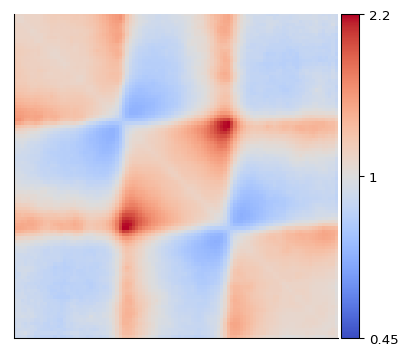

In [13]:
plotpup.make_heatmap_grid(pup,
                          score=False,
                          height=5)

And here are the domain scores for the first 10 TADs that went into the analysis!

In [14]:
pup.loc['all', 'domain_score'][:10]

[1.4328345466176964,
 1.5170487273138784,
 1.1292035396330244,
 1.1248278340407158,
 0.8589574596541815,
 2.5630210110148615,
 1.4948652180585305,
 1.4765717155999951,
 1.4497811538539718,
 1.1762126061125198]

Their distribution using a violinplot:

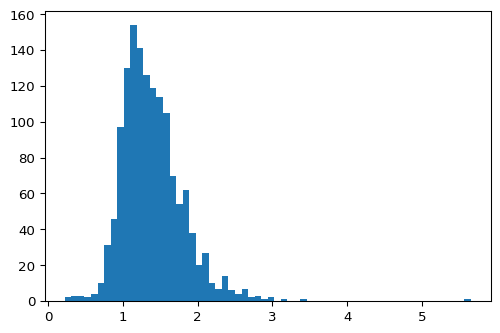

In [15]:
plt.hist(pup.loc['all', 'domain_score'], bins='auto');